<a href="https://colab.research.google.com/github/bksat90/FinalProject/blob/main/classification_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# necessary imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import PIL
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image, ImageFilter

In [2]:
# mounting gdrive.
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# # Unzip the images. (one time activity)
# !unzip "/content/drive/MyDrive/Project_BC/archive.zip" -d "/content/drive/MyDrive/Project_BC/cnn/"

# **Exploratory Data Analysis**

In [3]:
# find the data counts for training data
path = "/content/drive/MyDrive/Project_BC/cnn/train/"
tr_benign = len(os.listdir(path + "/0"))
tr_malignant = len(os.listdir(path + "/1"))
print('Number of benign images:' , tr_benign)
print('Number of malignant images:' , tr_malignant)

Number of benign images: 1569
Number of malignant images: 803


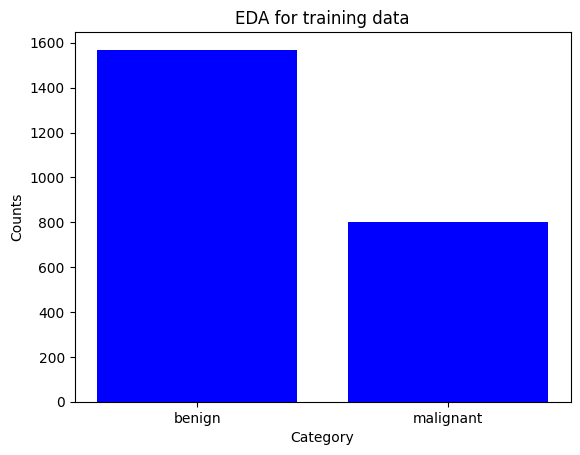

In [4]:
# depict the data into graph for training data
labels = ['benign', 'malignant']
counts = [tr_benign, tr_malignant]

plt.bar(labels, counts, color ='blue')
plt.xlabel('Category')
plt.ylabel('Counts')
plt.title('EDA for training data')
plt.show()

In [5]:
# find the data counts for test data
path = "/content/drive/MyDrive/Project_BC/cnn/test/"
tt_benign = len(os.listdir(path + "/0"))
tt_malignant = len(os.listdir(path + "/1"))
print('Number of benign images:', tt_benign)
print('Number of malignant images:', tt_malignant)

Number of benign images: 208
Number of malignant images: 128


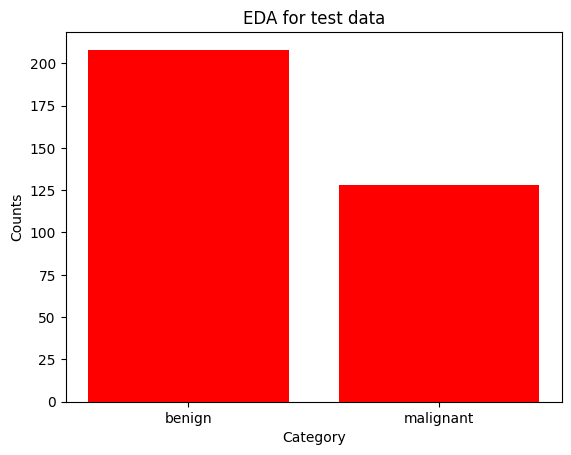

In [6]:
# depict the data into graph for test data
test_labels = ['benign', 'malignant']
test_counts = [tt_benign, tt_malignant]

plt.bar(test_labels, test_counts, color ='red')
plt.xlabel('Category')
plt.ylabel('Counts')
plt.title('EDA for test data')
plt.show()

# **Data Preprocessing**

In [7]:
# resize the images
def resize(picture, label):
    picture = tf.image.resize(tf.cast(picture, tf.float32),
                            size=[240,240]) /255.0
    return picture, label


In [11]:
# define median filter function
def median_filter(sourcepath, targetpath):
  for filename in os.listdir(sourcepath):
    pic = Image.open(sourcepath + filename)
    pic = pic.filter(ImageFilter.MedianFilter(size=3))
    pic.save(targetpath + filename)

In [14]:
def call_filter(srcpath, trgpath):
  # apply the filter for the benign images
  sourcepath = srcpath + "0/"
  targetpath = trgpath + "0/"
  median_filter(sourcepath, targetpath)

  # apply the filter for the malignant images
  sourcepath = srcpath + "1/"
  targetpath = trgpath + "1/"
  median_filter(sourcepath, targetpath)

In [ ]:
# apply the filter for the training images
srcpath = "/content/drive/MyDrive/Project_BC/cnn/train/"
trgpath = "/content/drive/MyDrive/Project_BC/median/train/"
call_filter(srcpath, trgpath)

In [ ]:
# apply the filter for the test images
srcpath = "/content/drive/MyDrive/Project_BC/cnn/test/"
trgpath = "/content/drive/MyDrive/Project_BC/median/test/"
call_filter(srcpath, trgpath)

In [14]:
print(sourcepath)

1569


In [ ]:
label_dict = {'benign' : 0,
              'malignant' : 1}

def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]
  label = tf.strings.to_number(label)

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label

img_loc = "/content/drive/MyDrive/Project_BC/cnn/"

train_list_ds = tf.data.Dataset.list_files(img_loc + "train/*/*")
valid_list_ds = tf.data.Dataset.list_files(img_loc + "valid/*/*")

In [ ]:
# def img_process(image, label):
#   image = tf.cast(image, tf.float32)
#   image = tf.image.resize(image, size=[240,240])
#   image = image / 255.0
#   return image, label

In [ ]:
train_ds = train_list_ds
val_ds = valid_list_ds

# parsing and processing the training images
train_ds = (
    train_ds
    .shuffle(1000)
    .map(parse_image)
    .map(img_process)
    .prefetch(tf.data.AUTOTUNE)
    .batch(128)
    .cache()
)

# parsing and processing the validation images
val_ds = (
    val_ds
    .map(parse_image)
    .map(img_process)
    .prefetch(tf.data.AUTOTUNE)
    .batch(128)
    .cache()
)

In [ ]:
# input layer
input_layer = layers.Input(shape=(240, 240, 3), name='Input')

# convolutional layers
conv0 = layers.Conv2D(16, (5, 5), activation='relu', padding="same",
                      strides=(2, 2), name='Conv0')(input_layer)
conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv1')(conv0)
conv2 = layers.Conv2D(32, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv2')(conv1)
pool1 = layers.MaxPooling2D((2, 2), name='Pool1')(conv2)

conv3 = layers.Conv2D(64, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv3')(pool1)
conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv4')(conv3)
pool2 = layers.MaxPooling2D((2, 2), name='Pool2')(conv4)

conv5 = layers.Conv2D(128, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv5')(pool2)
conv6 = layers.Conv2D(128, (3, 3), activation='relu', padding="same",
                      strides=(1, 1), name='Conv6')(conv5)
global_pool = layers.GlobalAveragePooling2D(name='GlobalPool')(conv6)

# fully connected layers
fc1 = layers.Dense(240, activation='relu', name='FC1')(global_pool)

# output layer
output_layer = layers.Dense(1, activation='sigmoid', name='Output')(fc1)

# create the model
model = models.Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                   │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv0 (Conv2D)                       │ (None, 120, 120, 16)        │           1,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv1 (Conv2D)                       │ (None, 120, 120, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2 (Conv2D)                       │ (None, 120, 120, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool1 (MaxPooling2D)                 │ (None, 60, 60, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv3 (Conv2D)                       │ (None, 60, 60, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv4 (Conv2D)                       │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Pool2 (MaxPooling2D)                 │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv5 (Conv2D)                       │ (None, 30, 30, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv6 (Conv2D)                       │ (None, 30, 30, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GlobalPool (GlobalAveragePooling2D)  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ FC1 (Dense)                          │ (None, 240)                 │          30,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 1)                   │             241 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 323,169 (1.23 MB)

 Trainable params: 323,169 (1.23 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
epoch_num = 100

history = model.fit(train_ds, validation_data=val_ds, epochs=epoch_num)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.6645 - loss: 0.6864 - val_accuracy: 0.6637 - val_loss: 0.6675
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.6645 - loss: 0.6580 - val_accuracy: 0.6637 - val_loss: 0.6591
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 199ms/step - accuracy: 0.6645 - loss: 0.6483 - val_accuracy: 0.6637 - val_loss: 0.6494
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.6645 - loss: 0.6435 - val_accuracy: 0.6637 - val_loss: 0.6467
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 198ms/step - accuracy: 0.6645 - loss: 0.6408 - val_accuracy: 0.6637 - val_loss: 0.6432
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 198ms/step - accuracy: 0.6645 - loss: 0.6386 - val_accuracy: 0.6637 - val_loss: 0.6411
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.6645 - loss: 0.6375 - val_accuracy: 0.6637 - val_loss: 0.6401
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 199ms/step - accuracy: 0.6645 - loss: 0.6369 - val_accuracy: 0.66

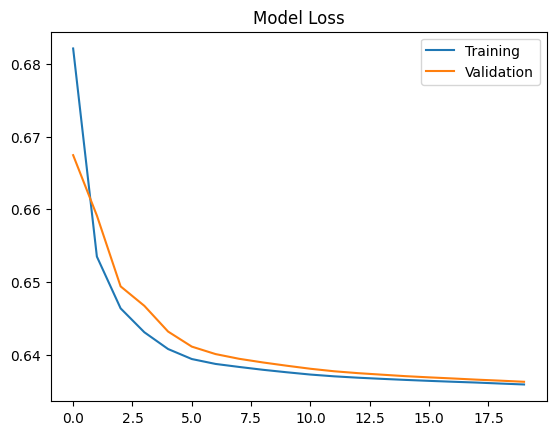

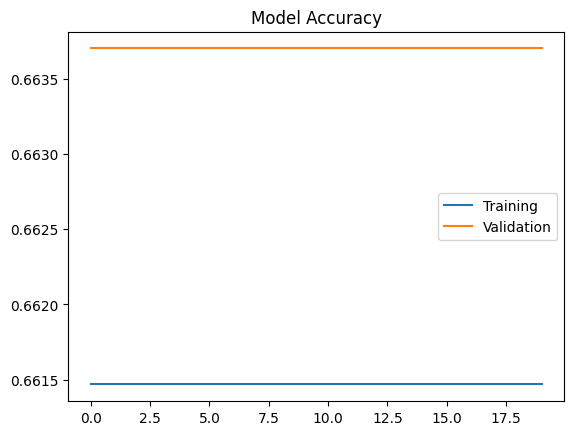

In [ ]:
plt.figure()
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend(loc=0)
plt.title('Model Loss')

plt.figure()
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.legend(loc=0)
plt.title('Model Accuracy')

plt.show()